# A Chemistry-Based Approach to Estimating NBA Team Power: An N-Max Framework

## By Dylan Hong for Math 76 with Professor Timmy Ma

In [21]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguedashlineups
from nba_api.stats.endpoints import leaguedashplayerstats
from nba_api.stats.endpoints import teamdashlineups
from nba_api.stats.endpoints import leaguegamelog
from nba_api.stats.endpoints import commonteamroster
from nba_api.stats.endpoints import leaguestandings
import statsmodels.api as sm
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import numpy as np
import time

In [22]:
#Gets Lineup Data from API for a given season
def LineupData(season,per):
    tempdf = leaguedashlineups.LeagueDashLineups(measure_type_detailed_defense = 'Base', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    
    tempdf1 = tempdf[['GROUP_ID','GP','PLUS_MINUS']].copy()
    
    print("done")
    return(tempdf1)

In [23]:
#Gets Player Data from API for a given season
def PlayerData(season,per):
    tempdf1 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Base', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf2 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Advanced', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf3 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Usage', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf4 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Misc', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    time.sleep(1)
    tempdf5 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Scoring', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    tempdf6 = leaguedashplayerstats.LeagueDashPlayerStats(measure_type_detailed_defense = 'Defense', 
                                                 season = season, 
                                                 per_mode_detailed = per).get_data_frames()[0]
    
    tempdf = pd.merge(tempdf1,tempdf2, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf3, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf4, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf5, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    tempdf = pd.merge(tempdf,tempdf6, on='PLAYER_ID', how='outer', suffixes = ('','_y'))
    
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('RANK')]]
    tempdf = tempdf[tempdf.columns[~tempdf.columns.str.contains('_y')]]
    
    print('done')
    return(tempdf)

In [47]:
#Returns dictionary of N-scores for given players in given set of attributes
def nMax(n,playerids,attributes,df):
    teamscore = 0
    #Loop through players in lineup
    teamAttr = defaultdict(list)
    for player in playerids:
        try:
            playerstats = df.loc[df['PLAYER_ID'] == int(player)]
            
            for attr in attributes:
                playerscore = playerstats.iloc[0][attr]
                teamAttr[attr].append(playerscore)

        except:
            continue            
            
    rawAttr = defaultdict()
    for x in teamAttr:
        teamAttr[x].sort(reverse = True)
        teamAttr[x] = teamAttr[x][:n]
        rawAttr[x] = sum(teamAttr[x][:n])
    return(rawAttr)

In [25]:
#Gets the most played lineups for each team during the given season
def GetLineups(season):
    nba_teams = teams.get_teams()

    teamLineups = defaultdict(str)
    for team in nba_teams:
        teamid = team['id']
        teamdf = teamdashlineups.TeamDashLineups(team_id = teamid, season = season, per_mode_detailed = 'Totals').get_data_frames()[1]
        #print(teamdf.head())
        teamdf.sort_values('MIN',ascending = False)
        teamLineups[team['abbreviation']] = teamdf.iat[0,1].split("-")[1:-1]
        #print("done")
        #print(teamLineups)
        time.sleep(1)
    
    print("done")
    return(teamLineups)

In [26]:
#Adds in player height and experience
def getPlayerInfo(df):
    nba_teams = teams.get_teams()
    tempdf = pd.DataFrame()

    for team in nba_teams:
        teamid = team['id']
        roster = commonteamroster.CommonTeamRoster(team_id = teamid,season = '2017-18').get_data_frames()[0]
        tempdf = tempdf.append(roster)

        time.sleep(1)

    newRoster = tempdf[['PLAYER_ID','HEIGHT','EXP']].copy()
    df = df.merge(newRoster,on='PLAYER_ID',how='left')
    
    for index, row in df.iterrows():
        if pd.isnull(row['HEIGHT']):
            df.at[index,'HEIGHT'] = 0   
        else:
            feet = row['HEIGHT'].split('-')[0]
            #print(feet)
            inches = row['HEIGHT'].split('-')[1]
            df.at[index,'HEIGHT'] = 12*int(feet) + int(inches)    
        exp = row['EXP']
        if exp == 'R' or pd.isnull(exp):
            df.at[index,'EXP'] = 0
        else:
            df.at[index,'EXP'] = int(exp)
    
    
    print("done")
    return(df)

In [27]:
#Get the log of games for a given season
def getGameLog(season):
    games = leaguegamelog.LeagueGameLog(season_all_time = season).get_data_frames()[0]
    games.drop_duplicates('GAME_ID',inplace = True)
    dummy = pd.get_dummies(games['WL'])
    games = pd.concat([games,dummy],axis = 1)
    
    return(games)

In [28]:
dfLineup = LineupData('2017-18','Per100Possessions')
dfPlayer = PlayerData('2017-18','Per100Possessions')
dfPlayer = getPlayerInfo(dfPlayer)
teamLineups = GetLineups('2017-18')
print(len(dfLineup))
print(len(dfPlayer))
print(len(teamLineups))
#print(list(dfPlayer.columns))
dfPlayer.head()

done
done
done
done
2000
540
30


,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,...,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,DEF_WS,HEIGHT,EXP
0,201166,Aaron Brooks,1610612750,MIN,33.0,32,19,13,0.594,47.1,...,0.240,0.118,0.882,0.818,0.182,0.393,0.607,0.014,72,9
1,203932,Aaron Gordon,1610612753,ORL,22.0,58,19,39,0.328,47.6,...,0.407,0.488,0.512,0.835,0.165,0.595,0.405,0.129,81,3
2,1626151,Aaron Harrison,1610612742,DAL,23.0,9,2,7,0.222,48.6,...,0.233,0.300,0.700,1.000,0.000,0.632,0.368,0.066,78,2
3,1628935,Aaron Jackson,1610612745,HOU,32.0,1,0,1,0.000,51.5,...,0.500,0.500,0.500,0.000,1.000,0.333,0.667,0.146,75,0
4,1627846,Abdel Nader,1610612738,BOS,24.0,48,33,15,0.688,47.2,...,0.342,0.333,0.667,0.957,0.043,0.620,0.380,0.150,78,0


In [29]:
#Set attributes
attributes = ['AST','OREB','DREB','BLK','FG_PCT','FG3_PCT','STL','TOV','OFF_RATING','DEF_RATING','PF','PTS','HEIGHT','EXP']

#rand = nMax(2,['2585', '201142', '201939', '202691', '203110'],attributes)
#print(rand)

In [59]:
masterVals = defaultdict(list)
N = 3
for key, value in teamLineups.items():
    vals = nMax(N,value,attributes,dfPlayer)
    
    #Get averages to normalize
    for key1, value1 in vals.items():
        masterVals[key1].append(value1)

#Get normalized coefficients
normalCoeffs = defaultdict(float)
L = 1
for x in masterVals:
        normalCoeffs[x] = (L/np.mean(masterVals[x]))

#Work with coefficients
#Offensive
normalCoeffs['AST'] = normalCoeffs['AST'] * 2
normalCoeffs['OREB'] = normalCoeffs['OREB'] * 2
normalCoeffs['FG_PCT'] = normalCoeffs['FG_PCT'] * 1
normalCoeffs['FG3_PCT'] = normalCoeffs['FG3_PCT'] * 1
normalCoeffs['TOV'] = normalCoeffs['TOV'] * -2
normalCoeffs['OFF_RATING'] = normalCoeffs['OFF_RATING'] * 2
normalCoeffs['PTS'] = normalCoeffs['PTS'] * 1

#Defensive
normalCoeffs['DREB'] = normalCoeffs['DREB'] * 1
normalCoeffs['STL'] = normalCoeffs['STL'] * 2
normalCoeffs['DEF_RATING'] = normalCoeffs['DEF_RATING'] * - 1
normalCoeffs['PF'] = normalCoeffs['PF'] * -2

#Attributes
normalCoeffs['HEIGHT'] = normalCoeffs['HEIGHT'] * 1
normalCoeffs['EXP'] = normalCoeffs['EXP'] * 2

#print(normalCoeffs)

#Calculate score for each team
teamRank = defaultdict(int)
for key, value in teamLineups.items():
    vals = nMax(N,value,attributes,dfPlayer)
    
    score = 0
    test = {}
    for key1,value1 in vals.items():
        score = score + (normalCoeffs[key1]*value1)
        test[key1] = normalCoeffs[key1]*value1
        
    teamRank[key] = score
    
print(teamRank)
print(test)

defaultdict(<class 'int'>, {'ATL': 10.005317450595925, 'BOS': 10.577661157038216, 'CLE': 11.456398251146997, 'NOP': 12.46371258944976, 'CHI': 9.38628197202379, 'DAL': 10.249556963329663, 'DEN': 11.195910368078025, 'GSW': 12.600342281493845, 'HOU': 13.38864325787243, 'LAC': 11.000397606861835, 'LAL': 9.241498886563491, 'MIA': 11.716106629586571, 'MIL': 10.843805547412883, 'MIN': 11.84977903448418, 'BKN': 10.024593740072625, 'NYK': 11.52203991746499, 'ORL': 9.67940896094243, 'IND': 11.684880750842062, 'PHI': 10.60745954584338, 'PHX': 10.030279245699749, 'POR': 10.010096025307258, 'SAC': 9.059193557672497, 'SAS': 12.741536375050764, 'OKC': 13.138308039346093, 'TOR': 11.344903109994098, 'UTA': 11.596353928212324, 'MEM': 9.688283429211113, 'WAS': 10.540678873384563, 'DET': 10.509166804960222, 'CHA': 11.84740570005825})
{'AST': 1.8883974140864241, 'OREB': 2.1420071400237997, 'DREB': 1.0518987341772155, 'BLK': 0.9759876065065841, 'FG_PCT': 1.0166197560648709, 'FG3_PCT': 0.9773419978147103, 'S

## Results for a Single Game

In [60]:
#First get log of all the games for the season
games = getGameLog('2017-18')
print("There are " + str(len(games)) + " in the season.")

#Add in Scores to games
for index, row in games.iterrows():
    home = row['MATCHUP'].split(' ')[0]
    away = row['MATCHUP'].split(' ')[2]
    games.at[index,'homeScore'] = teamRank[home]
    games.at[index,'awayScore'] = teamRank[away]
    games.at[index,'netScore'] = teamRank[home] - teamRank[away]
    
games.head()

There are 1230 in the season.


,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE,L,W,homeScore,awayScore,netScore
0,22017,1610612744,GSW,Golden State Warriors,0021700002,2017-10-17,GSW vs. HOU,L,240,43,...,17,25,121,-1,1,1,0,12.600342,13.388643,-0.788301
2,22017,1610612738,BOS,Boston Celtics,0021700001,2017-10-17,BOS @ CLE,L,240,36,...,12,24,99,-3,1,1,0,10.577661,11.456398,-0.878737
4,22017,1610612750,MIN,Minnesota Timberwolves,0021700011,2017-10-18,MIN @ SAS,L,240,37,...,13,16,99,-8,1,1,0,11.849779,12.741536,-0.891757
6,22017,1610612757,POR,Portland Trail Blazers,0021700012,2017-10-18,POR @ PHX,W,240,44,...,18,20,124,48,1,0,1,10.010096,10.030279,-0.020183
8,22017,1610612738,BOS,Boston Celtics,0021700007,2017-10-18,BOS vs. MIL,L,240,39,...,15,27,100,-8,1,1,0,10.577661,10.843806,-0.266144


In [97]:
#Run Regressions on results
exog = sm.add_constant(games['netScore'])

model1 = sm.OLS(games['PLUS_MINUS'],games['netScore']).fit()
model2 = sm.OLS(games['PLUS_MINUS'],exog).fit()
model3 = sm.OLS(games['W'],games['netScore']).fit()
model4 = sm.OLS(games['W'],exog).fit()
model5 = sm.Logit(games['W'],games['netScore']).fit()
model5.summary()

Optimization terminated successfully.
         Current function value: 43.908455
         Iterations 5


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/anaconda3/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:3313: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      W   No. Observations:                 1230
Model:                          Logit   Df Residuals:                     1229
Method:                           MLE   Df Model:                            0
Date:                Wed, 06 Mar 2019   Pseudo R-squ.:                     inf
Time:                        11:37:06   Log-Likelihood:                -54007.
converged:                       True   LL-Null:                        0.0000
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
netScore       0.3672      0.038      9.548      0.000       0.292       0.443
==============================================================================
"""

Text(0, 0.5, 'Plus - Minus')

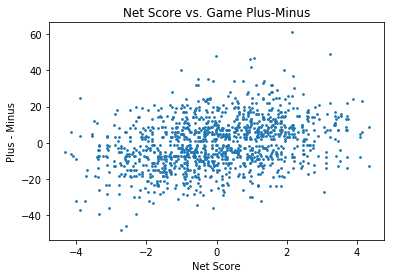

In [72]:
#Plot the results
plt.figure(1)
plt.scatter(games['netScore'],games['PLUS_MINUS'],s = 3)
#plt.scatter(games['netScore'],games['W'],s = 3)
plt.title("Net Score vs. Game Plus-Minus")
plt.xlabel("Net Score")
plt.ylabel("Plus - Minus")

In [70]:
#Examine the proportion of correctly predicted games in a sesaon
total = 0
correct = 0 
for index, row in games.iterrows():
    if row['W'] == 1 and row['netScore'] > 0:
        correct = correct + 1
        total = total + 1
    elif row['W'] == 0 and row['netScore'] < 0:
        correct = correct + 1
        total = total + 1
    elif row['W'] == 1 and row['netScore'] < 0:
        total = total + 1
    elif row['W'] == 0 and row['netScore'] > 0:
        total = total + 1
print(correct)
print(total)
print(correct/total)

757
1230
0.6154471544715447


## Results for a Season

In [54]:
#Get standings for the season
stand = leaguestandings.LeagueStandings(season = '2017-18').get_data_frames()[0]
nba_teams = teams.get_teams()

for index, row in stand.iterrows():
    preaswin = row['PreAS'].split('-')[0]
    stand.at[index,'PreASWins'] = int(preaswin)0
    postaswin = row['PostAS'].split('-')[0]
    stand.at[index,'PostASWins'] = int(postaswin)

lookup = {}
for team in nba_teams:
    teamid = team['id']
    lookup[team['nickname']] = team['abbreviation']

for index, row in stand.iterrows():
    name = row['TeamName']
    if name == 'Bobcats':
        abbrev = 'CHA'
    if name == 'SuperSonics':
        abbrev = 'OKC'
    else:
        abbrev = lookup[name]
    stand.at[index,'score'] = teamRank[abbrev]

#print(stand['WINS'])
stand.head()

,LeagueID,SeasonID,TeamID,TeamCity,TeamName,Conference,ConferenceRecord,PlayoffRank,ClinchIndicator,Division,...,Aug,Sep,Oct,Nov,Dec,PreAS,PostAS,PreASWins,PostASWins,score
0,00,22017,1610612761,Toronto,Raptors,East,40-12,1,- e,Atlantic,...,None,None,4-2,9-5,11-3,41-16,18-7,41.0,18.0,1134.490311
1,00,22017,1610612745,Houston,Rockets,West,41-11,1,- w,Southwest,...,None,None,5-3,12-1,9-5,44-13,21-4,44.0,21.0,1338.864326
2,00,22017,1610612738,Boston,Celtics,East,33-19,2,- x,Atlantic,...,None,None,5-2,14-2,11-6,40-19,15-8,40.0,15.0,1057.766116
3,00,22017,1610612744,Golden State,Warriors,West,34-18,2,- p,Pacific,...,None,None,5-3,11-3,13-2,44-14,14-10,44.0,14.0,1260.034228
4,00,22017,1610612757,Portland,Trail Blazers,West,31-21,3,- nw,Northwest,...,None,None,4-3,9-6,5-8,32-26,17-7,32.0,17.0,1001.009603


In [113]:
#Run Regressions on Results
model = sm.OLS(stand['WINS'],stand['score']).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   WINS   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     550.8
Date:                Wed, 06 Mar 2019   Prob (F-statistic):           2.06e-20
Time:                        13:02:48   Log-Likelihood:                -110.28
No. Observations:                  30   AIC:                             222.6
Df Residuals:                      29   BIC:                             224.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
score          0.0377      0.002     23.469      0.000       0.034       0.041
==============================================================================
Omnibus:                        2.301   Durbin-Watson:                   0.261
Prob(Omnibus):                  0.317   Jarque-Bera (JB):                1.218
Skew:                          -0.041   Prob(JB):                        0.544
Kurtosis:                       2.016   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Wins')

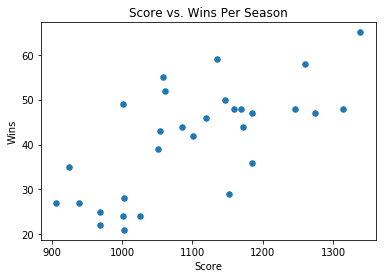

In [114]:
#Plot the results
plt.figure(1)
plt.scatter(stand['score'],stand['WINS'],s = 30)
plt.title("Score vs. Wins Per Season")
plt.xlabel("Score")
plt.ylabel("Wins")

## Predicting End of Season Standings

In [115]:
#Train the Model on last years statistics
dfLineupPred = LineupData('2016-17','Per100Possessions')
dfPlayerPred = PlayerData('2016-17','Per100Possessions')
dfPlayerPred = getPlayerInfo(dfPlayerPred)
teamLineupsPred = GetLineups('2017-18')
results = leaguestandings.LeagueStandings(season = '2017-18').get_data_frames()[0]
print(len(dfLineup))
print(len(dfPlayer))
print(len(teamLineups))
#print(list(dfPlayer.columns))
dfPlayer.head()

done
done
done
done
2000
540
30


,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,AGE,GP,W,L,W_PCT,MIN,...,PCT_PTS_PAINT,PCT_AST_2PM,PCT_UAST_2PM,PCT_AST_3PM,PCT_UAST_3PM,PCT_AST_FGM,PCT_UAST_FGM,DEF_WS,HEIGHT,EXP
0,201166,Aaron Brooks,1610612750,MIN,33.0,32,19,13,0.594,47.1,...,0.240,0.118,0.882,0.818,0.182,0.393,0.607,0.014,72,9
1,203932,Aaron Gordon,1610612753,ORL,22.0,58,19,39,0.328,47.6,...,0.407,0.488,0.512,0.835,0.165,0.595,0.405,0.129,81,3
2,1626151,Aaron Harrison,1610612742,DAL,23.0,9,2,7,0.222,48.6,...,0.233,0.300,0.700,1.000,0.000,0.632,0.368,0.066,78,2
3,1628935,Aaron Jackson,1610612745,HOU,32.0,1,0,1,0.000,51.5,...,0.500,0.500,0.500,0.000,1.000,0.333,0.667,0.146,75,0
4,1627846,Abdel Nader,1610612738,BOS,24.0,48,33,15,0.688,47.2,...,0.342,0.333,0.667,0.957,0.043,0.620,0.380,0.150,78,0


In [116]:
attributes = ['AST','OREB','DREB','BLK','FG_PCT','FG3_PCT','STL','TOV','OFF_RATING','DEF_RATING','PF','PTS','HEIGHT','EXP']

masterVals = defaultdict(list)
N = 3
for key, value in teamLineupsPred.items():
    vals = nMax(N,value,attributes,dfPlayerPred) #Not all players have stats - rookies #put in rookie as all 0s
    
    #Get averages to normalize
    for key1, value1 in vals.items():
        masterVals[key1].append(value1)

#Get normalized coefficients
normalCoeffs = defaultdict(float)
L = 100
for x in masterVals:
        normalCoeffs[x] = (L/np.mean(masterVals[x]))

#Work with coefficients
#Offensive
normalCoeffs['AST'] = normalCoeffs['AST'] * 2
normalCoeffs['OREB'] = normalCoeffs['OREB'] * 2
normalCoeffs['FG_PCT'] = normalCoeffs['FG_PCT'] * 1
normalCoeffs['FG3_PCT'] = normalCoeffs['FG3_PCT'] * 1
normalCoeffs['TOV'] = normalCoeffs['TOV'] * -2
normalCoeffs['OFF_RATING'] = normalCoeffs['OFF_RATING'] * 2
normalCoeffs['PTS'] = normalCoeffs['PTS'] * 1

#Defensive
normalCoeffs['DREB'] = normalCoeffs['DREB'] * 1
normalCoeffs['STL'] = normalCoeffs['STL'] * 2
normalCoeffs['DEF_RATING'] = normalCoeffs['DEF_RATING'] * -1
normalCoeffs['PF'] = normalCoeffs['PF'] * -2

#Attributes
normalCoeffs['HEIGHT'] = normalCoeffs['HEIGHT'] * 1
normalCoeffs['EXP'] = normalCoeffs['EXP'] * 2

#print(normalCoeffs)

#Calculate score for each team
teamRankPred = defaultdict(int)
for key, value in teamLineups.items():
    vals = nMax(N,value,attributes,dfPlayerPred)
    
    score = 0
    test = {}
    for key1,value1 in vals.items():
        score = score + (normalCoeffs[key1]*value1)
        test[key1] = normalCoeffs[key1]*value1
        
    teamRankPred[key] = score
    
print(teamRankPred)
print(test)

defaultdict(<class 'int'>, {'ATL': 929.2429162751387, 'BOS': 1022.0502525290943, 'CLE': 1220.7335714542337, 'NOP': 1314.8357534919437, 'CHI': 926.0970893197799, 'DAL': 940.9708288954553, 'DEN': 1124.9778295745025, 'GSW': 1434.8904560295273, 'HOU': 1408.2064941447677, 'LAC': 1089.6696539447748, 'LAL': 794.269968582912, 'MIA': 1167.8627210544482, 'MIL': 1120.526503869188, 'MIN': 1264.9661787526725, 'BKN': 999.0438982093956, 'NYK': 1100.112525180343, 'ORL': 973.7847977409515, 'IND': 1056.3164529614085, 'PHI': 936.5200360483379, 'PHX': 1056.336837114544, 'POR': 1069.0130168755747, 'SAC': 692.7558044979612, 'SAS': 1142.5434769689728, 'OKC': 1270.0261279028691, 'TOR': 1163.9817783780222, 'UTA': 1275.0010498186432, 'MEM': 968.0495931300916, 'WAS': 1088.0781129793638, 'DET': 1119.7812183863361, 'CHA': 1329.355055888746})
{'AST': 210.4286509556504, 'OREB': 280.9123649459784, 'DREB': 124.34417628541449, 'BLK': 111.5506329113924, 'FG_PCT': 106.78455265930644, 'FG3_PCT': 100.52647878600186, 'STL':

In [117]:
#Put into eastern and western standings
eastern = defaultdict(list)
western = defaultdict(list)

predStanding = defaultdict(int)
for key,value in teamRankPred.items():
    wins = model.predict(value)
    wins = round(wins[0])
    predStanding[key] = wins

predStanding

defaultdict(int,
            {'ATL': 35.0,
             'BOS': 38.0,
             'CLE': 46.0,
             'NOP': 50.0,
             'CHI': 35.0,
             'DAL': 35.0,
             'DEN': 42.0,
             'GSW': 54.0,
             'HOU': 53.0,
             'LAC': 41.0,
             'LAL': 30.0,
             'MIA': 44.0,
             'MIL': 42.0,
             'MIN': 48.0,
             'BKN': 38.0,
             'NYK': 41.0,
             'ORL': 37.0,
             'IND': 40.0,
             'PHI': 35.0,
             'PHX': 40.0,
             'POR': 40.0,
             'SAC': 26.0,
             'SAS': 43.0,
             'OKC': 48.0,
             'TOR': 44.0,
             'UTA': 48.0,
             'MEM': 36.0,
             'WAS': 41.0,
             'DET': 42.0,
             'CHA': 50.0})

In [118]:
#Look at Mid Season Trades

In [119]:
from nba_api.stats.endpoints import playoffpicture

playoff = playoffpicture.PlayoffPicture(season_id = '22017').get_data_frames()[0]
playoff.head(20)

,CONFERENCE,HIGH_SEED_RANK,HIGH_SEED_TEAM,HIGH_SEED_TEAM_ID,LOW_SEED_RANK,LOW_SEED_TEAM,LOW_SEED_TEAM_ID,HIGH_SEED_SERIES_W,HIGH_SEED_SERIES_L,HIGH_SEED_SERIES_REMAINING_G,HIGH_SEED_SERIES_REMAINING_HOME_G,HIGH_SEED_SERIES_REMAINING_AWAY_G
0,East,1,Toronto,1610612761,8,Washington,1610612764,2,2,0,0,0
1,East,2,Boston,1610612738,7,Milwaukee,1610612749,2,2,0,0,0
2,East,3,Philadelphia,1610612755,6,Miami,1610612748,2,2,0,0,0
3,East,4,Cleveland,1610612739,5,Indiana,1610612754,1,3,0,0,0


## ALL-STAR BREAK PREDICTIONS

In [ ]:
#Train the Model on last years statistics
dfLineupAll = LineupData('2016-17','Per100Possessions')
dfPlayerAll = PlayerData('2016-17','Per100Possessions')
dfPlayerAll = getPlayerInfo(dfPlayerPred)
teamLineupsAll = GetLineups('2017-18')
resultsAll = leaguestandings.LeagueStandings(season = '2017-18').get_data_frames()[0]
print(len(dfLineup))
print(len(dfPlayer))
print(len(teamLineups))
#print(list(dfPlayer.columns))
dfPlayer.head()

In [122]:
#AllStar = leaguestandings.LeagueStandings(season = '2017-18').get_data_frames()[0]

for index, row in resultsAll.iterrows():
    preaswin = row['PreAS'].split('-')[0]
    stand.at[index,'PreASWins'] = int(preaswin)
    postaswin = row['PostAS'].split('-')[0]
    stand.at[index,'PostASWins'] = int(postaswin)

exog = stand[['score','PreASWins']].copy()
model2 = sm.OLS(stand['PostASWins'],exog).fit()
model3 = sm.OLS(stand['PostASWins'],stand['score']).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             PostASWins   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     253.0
Date:                Wed, 06 Mar 2019   Prob (F-statistic):           7.34e-16
Time:                        13:20:16   Log-Likelihood:                -85.561
No. Observations:                  30   AIC:                             173.1
Df Residuals:                      29   BIC:                             174.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
score          0.0112      0.001     15.905      0.000       0.010       0.013
==============================================================================
Omnibus:                        0.296   Durbin-Watson:                   0.598
Prob(Omnibus):                  0.862   Jarque-Bera (JB):                0.250
Skew:                           0.195   Prob(JB):                        0.882
Kurtosis:                       2.781   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'Wins')

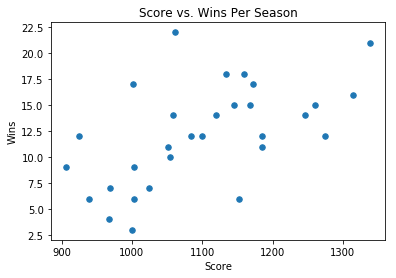

In [123]:
#Plot the results
plt.figure(1)
plt.scatter(stand['score'],stand['PostASWins'],s = 30)
#plt.scatter(stand['PreASWins'],stand['PostASWins'],s = 30)
plt.title("Score vs. Wins Per Season")
plt.xlabel("Score")
plt.ylabel("Wins")